In [1]:
import os
import sys
sys.path.append(os.getcwd())
import torch
import argparse
from model.deeplab import *
from tqdm import tqdm
import json
from utils.metrics import Evaluator
from data import spacenet
from common import config
from torch.utils.data import DataLoader
import numpy as np
import cv2
import torchvision
import matplotlib.pyplot as plt
import torch.nn
from model.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d

In [4]:
model_path_s = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.shanghai.n/train_log/best.pth'
model_path_p = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.paris.n/train_log/best.pth'
model_path_v = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.vegas.n/train_log/best.pth'
model_path_k = '/home/home1/xw176/work/Domain_Adaptation/configs/mobilenet.baseline/xh.deeplab.mobilenet.khartoum.n/train_log/best.pth'

cuda = True

In [5]:
# shanghai_set = spacenet.Spacenet(city=source_n, split='test', img_root=config.img_root)
# source_loader = DataLoader(source_set, batch_size=config.batch_size, shuffle=False, num_workers=0, drop_last=True)
# target_set = spacenet.Spacenet(city=target_n, split='test', img_root=config.img_root)
# target_loader = DataLoader(target_set, batch_size=config.batch_size, shuffle=False, num_workers=0, drop_last=True)

model_s = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)
model_p = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)
model_v = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)
model_k = DeepLab(num_classes=2,
        backbone=config.backbone,
        output_stride=config.out_stride,
        sync_bn=config.sync_bn,
        freeze_bn=True)

if cuda:
    checkpoint_s = torch.load(model_path_s)
    checkpoint_v = torch.load(model_path_v)
    checkpoint_p = torch.load(model_path_p)
    checkpoint_k = torch.load(model_path_k)
else:
    checkpoint_s = torch.load(model_path_s, map_location=torch.device('cpu'))
    checkpoint_v = torch.load(model_path_v, map_location=torch.device('cpu'))
    checkpoint_p = torch.load(model_path_p, map_location=torch.device('cpu'))
    checkpoint_k = torch.load(model_path_k, map_location=torch.device('cpu'))
    
model_s.load_state_dict(checkpoint_s)
model_v.load_state_dict(checkpoint_v)
model_p.load_state_dict(checkpoint_p)
model_k.load_state_dict(checkpoint_k)

# evaluator = Evaluator(2)
if cuda:
    model_s = model_s.cuda()
    model_v = model_v.cuda()
    model_p = model_p.cuda()
    model_k = model_k.cuda()
    
model_s.eval();
model_v.eval();
model_p.eval();
model_k.eval();

In [7]:
mean_s, mean_v, mean_p, mean_k = [], [], [], []
var_s, var_v, var_p, var_k = [], [], [], []

for h in model_s.modules():
    if isinstance(h, SynchronizedBatchNorm2d) or isinstance(h, nn.BatchNorm2d):
        mean_s.append(h.running_mean)
        var_s.append(h.running_var)

for h in model_v.modules():
    if isinstance(h, SynchronizedBatchNorm2d) or isinstance(h, nn.BatchNorm2d):
        mean_v.append(h.running_mean)
        var_v.append(h.running_var)

for h in model_p.modules():
    if isinstance(h, SynchronizedBatchNorm2d) or isinstance(h, nn.BatchNorm2d):
        mean_p.append(h.running_mean)
        var_p.append(h.running_var)
    
for h in model_k.modules():
    if isinstance(h, SynchronizedBatchNorm2d) or isinstance(h, nn.BatchNorm2d):
        mean_k.append(h.running_mean)
        var_k.append(h.running_var)

layer 0 : 32


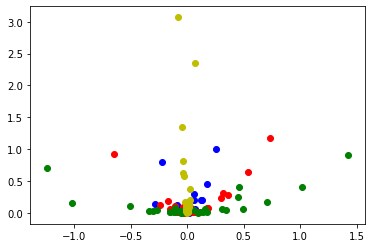

layer 1 : 32


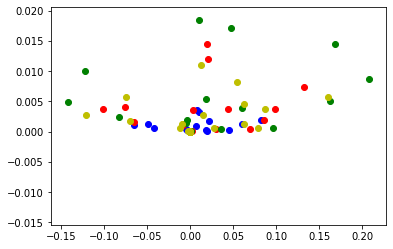

layer 2 : 16


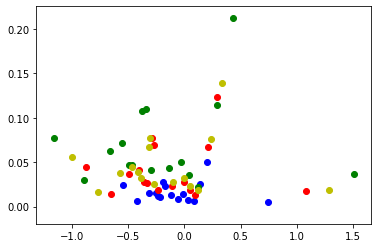

layer 3 : 96


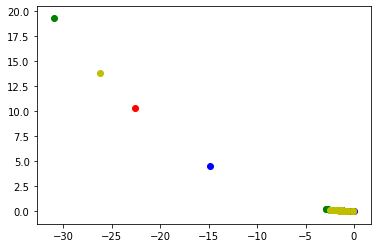

layer 4 : 96


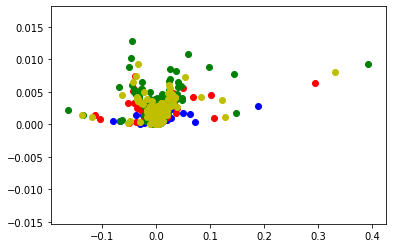

layer 5 : 24


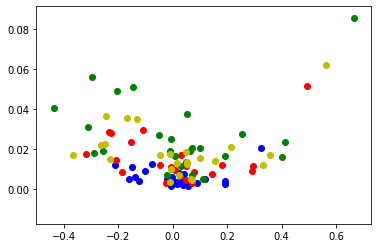

layer 6 : 144


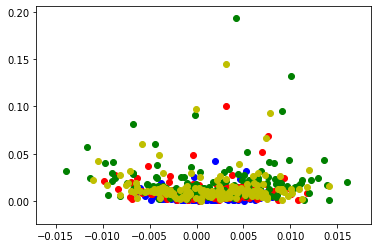

layer 7 : 144


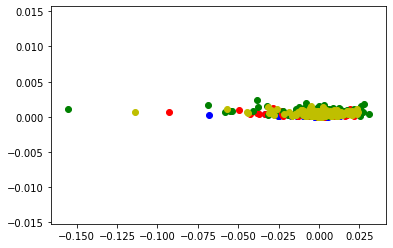

layer 8 : 24


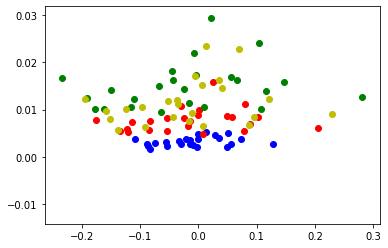

layer 9 : 144


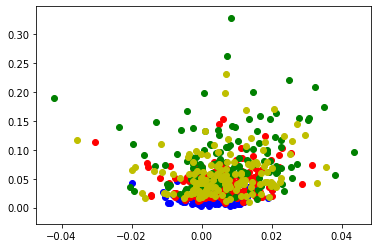

layer 10 : 144


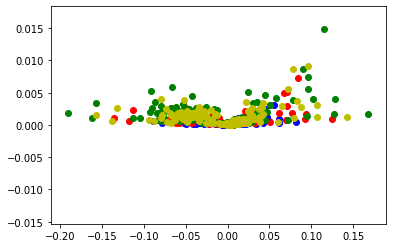

layer 11 : 32


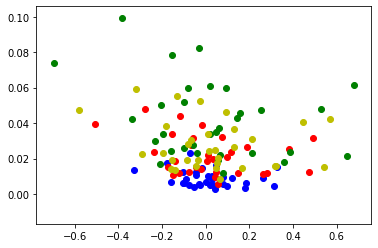

layer 12 : 192


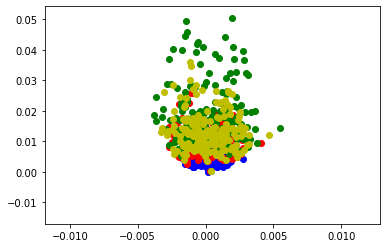

layer 13 : 192


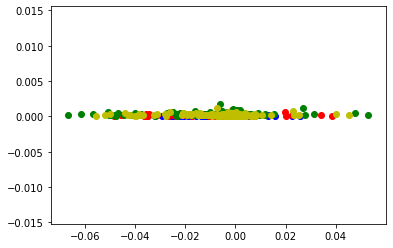

layer 14 : 32


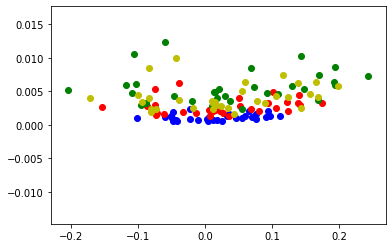

layer 15 : 192


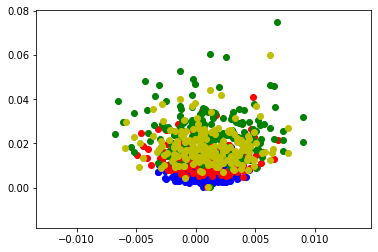

layer 16 : 192


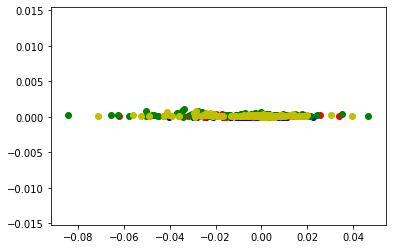

layer 17 : 32


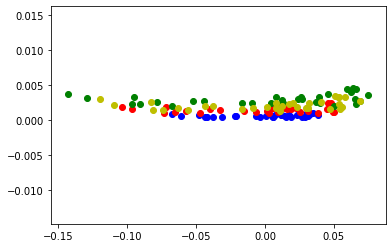

layer 18 : 192


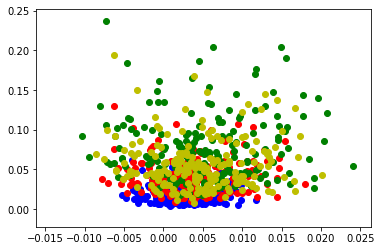

layer 19 : 192


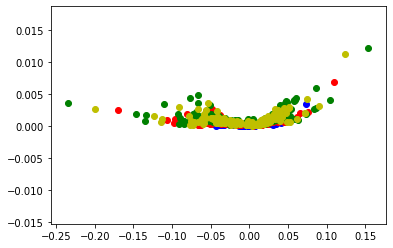

layer 20 : 64


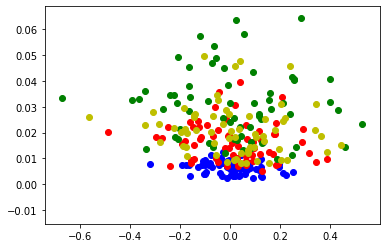

layer 21 : 384


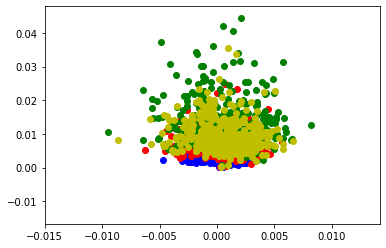

layer 22 : 384


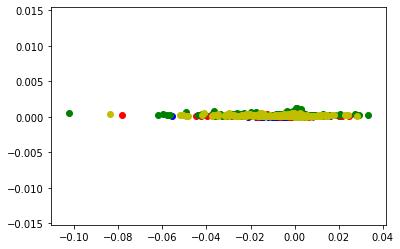

layer 23 : 64


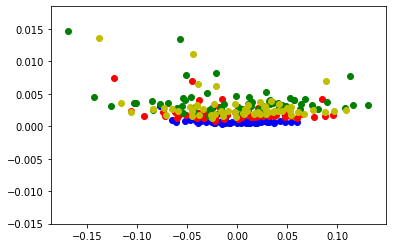

layer 24 : 384


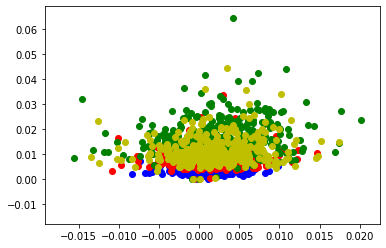

layer 25 : 384


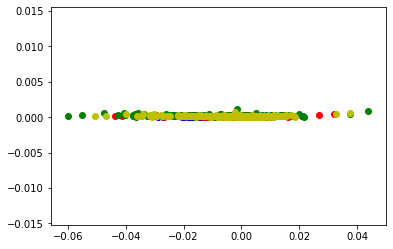

layer 26 : 64


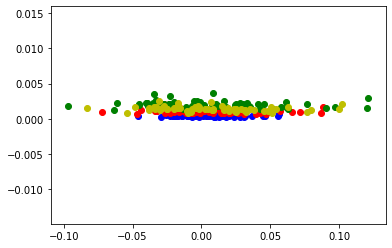

layer 27 : 384


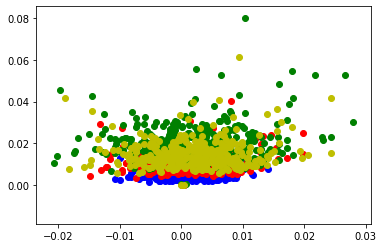

layer 28 : 384


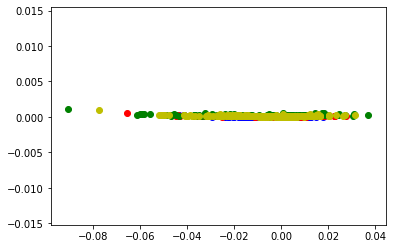

layer 29 : 64


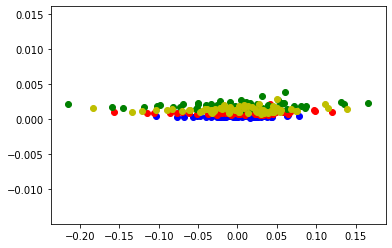

layer 30 : 384


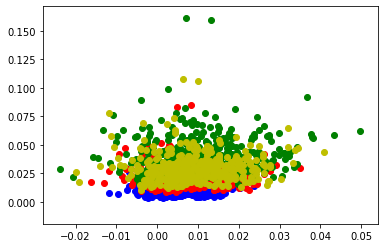

layer 31 : 384


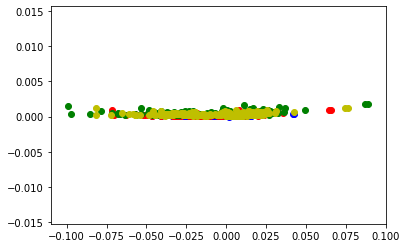

layer 32 : 96


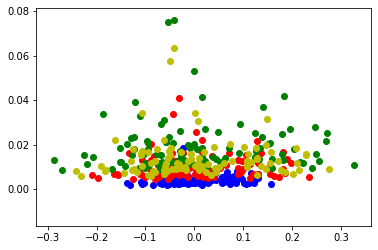

layer 33 : 576


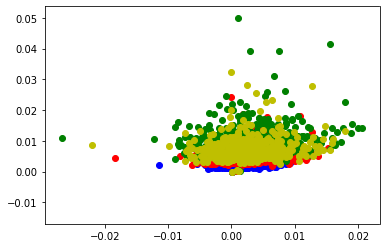

layer 34 : 576


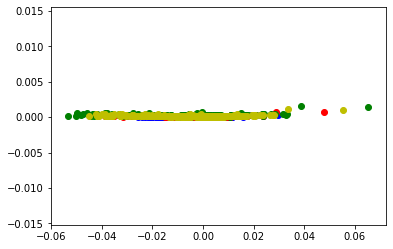

layer 35 : 96


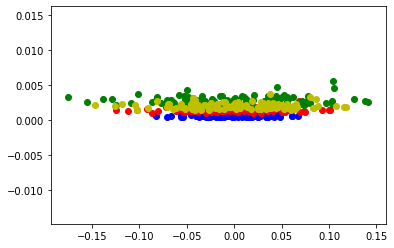

layer 36 : 576


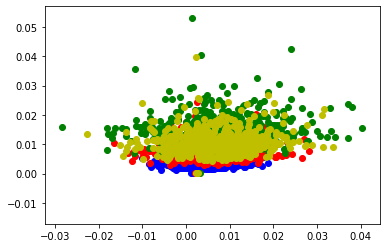

layer 37 : 576


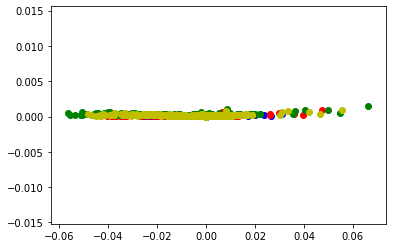

layer 38 : 96


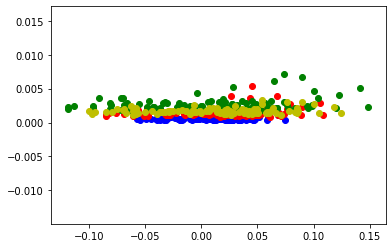

layer 39 : 576


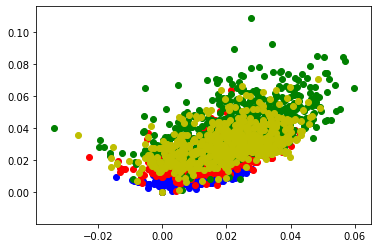

layer 40 : 576


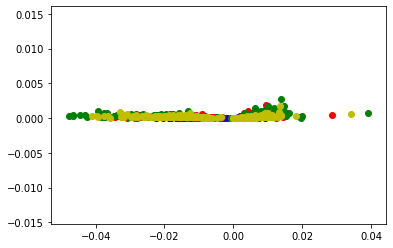

layer 41 : 160


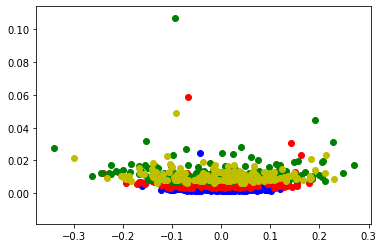

layer 42 : 960


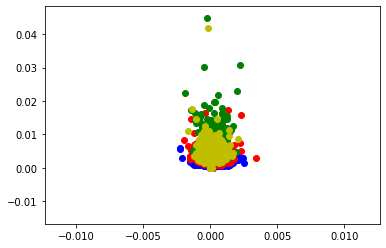

layer 43 : 960


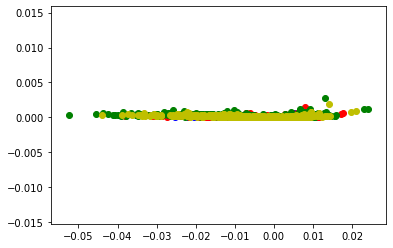

layer 44 : 160


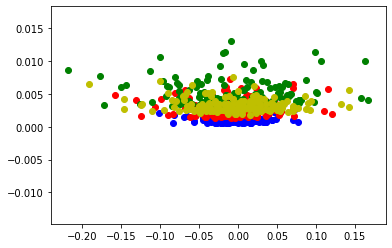

layer 45 : 960


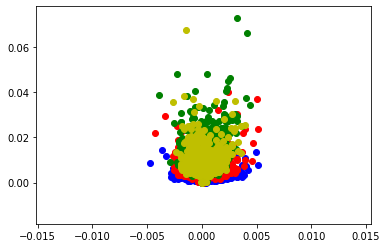

layer 46 : 960


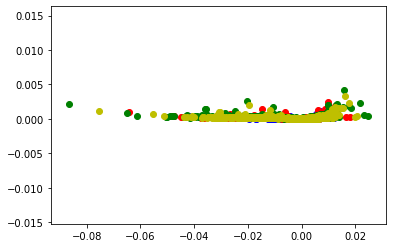

layer 47 : 160


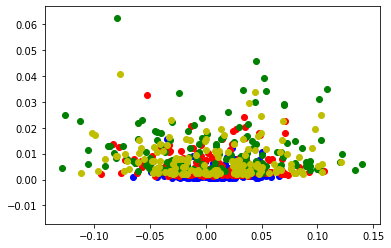

layer 48 : 960


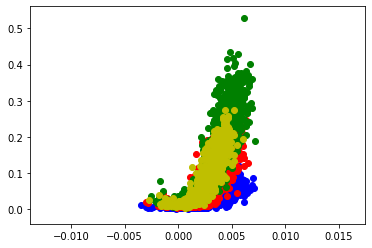

layer 49 : 960


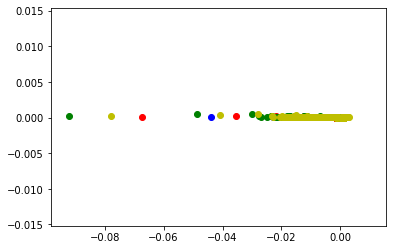

layer 50 : 320


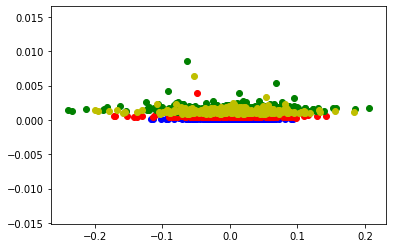

layer 51 : 256


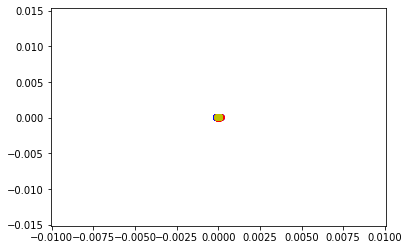

layer 52 : 256


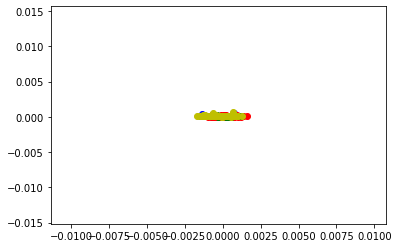

layer 53 : 256


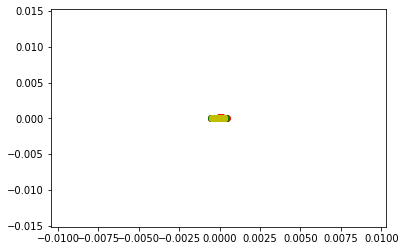

layer 54 : 256


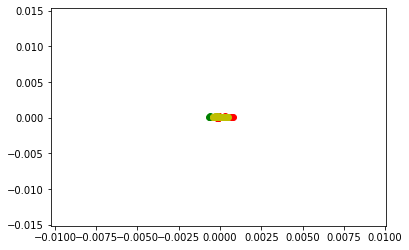

layer 55 : 256


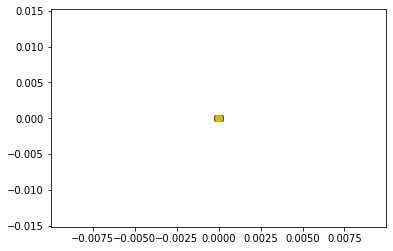

layer 56 : 256


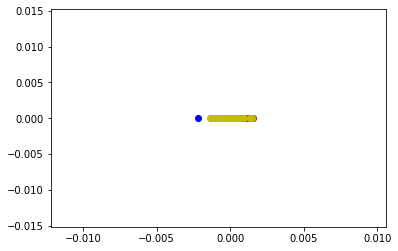

layer 57 : 48


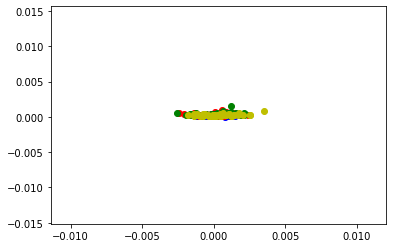

layer 58 : 256


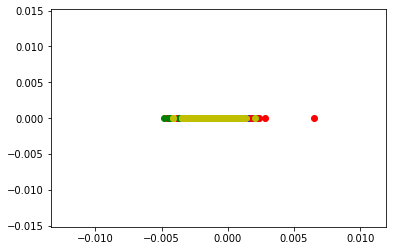

layer 59 : 256


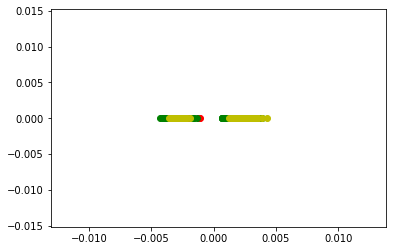

In [32]:
for i in range(len(mean_s)):
    mean_s[i] = mean_s[i].cpu()
    var_s[i] = var_s[i].cpu()
    mean_v[i] = mean_v[i].cpu()
    var_v[i] = var_v[i].cpu()
    mean_k[i] = mean_k[i].cpu()
    var_k[i] = var_k[i].cpu()
    mean_p[i] = mean_p[i].cpu()
    var_p[i] = var_p[i].cpu()

for i in range(len(mean_s)):
    print('layer', i, ':', len(mean_s[i]))
    plt.scatter(mean_s[i], var_s[i], c='b')
    plt.scatter(mean_v[i], var_v[i], c='r')
    plt.scatter(mean_p[i], var_p[i], c='g')
    plt.scatter(mean_k[i], var_k[i], c='y')
    plt.show()   

layer 0 : 32


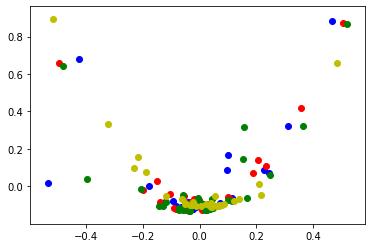

layer 1 : 32


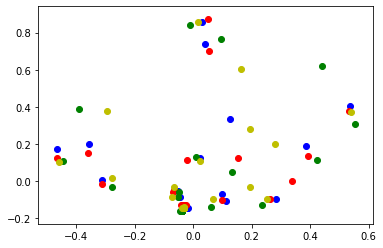

layer 2 : 16


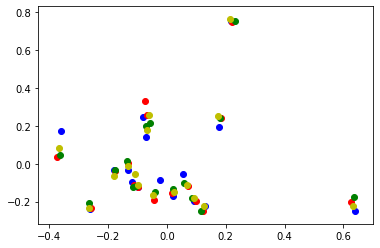

layer 3 : 96


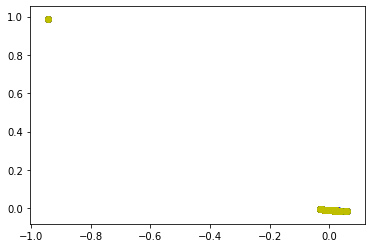

layer 4 : 96


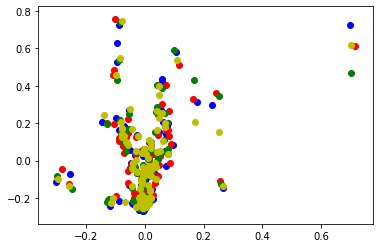

layer 5 : 24


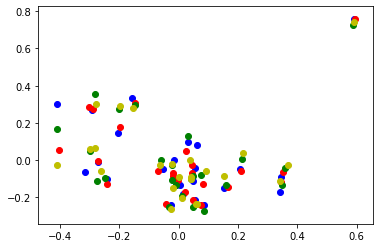

layer 6 : 144


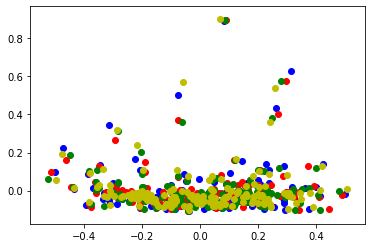

layer 7 : 144


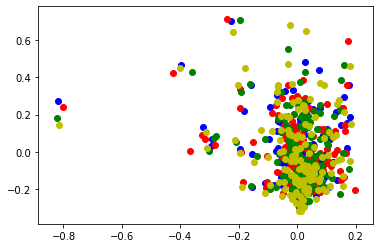

layer 8 : 24


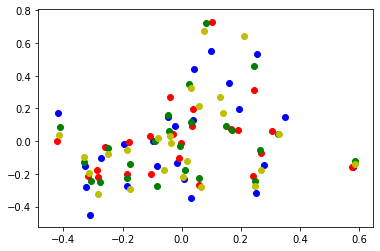

layer 9 : 144


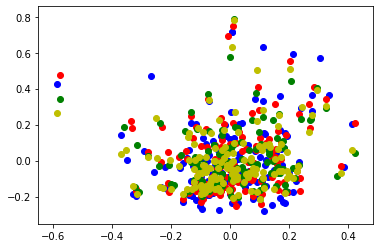

layer 10 : 144


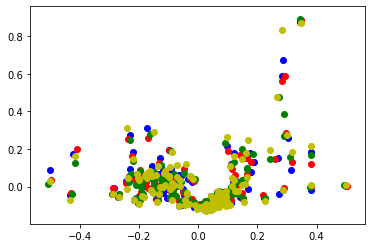

layer 11 : 32


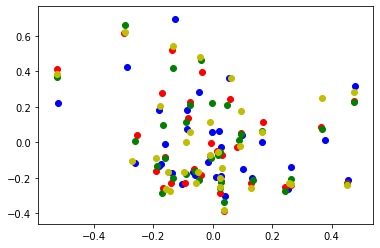

layer 12 : 192


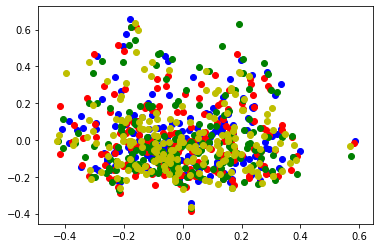

layer 13 : 192


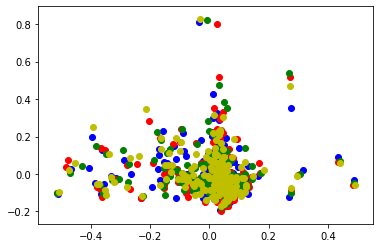

layer 14 : 32


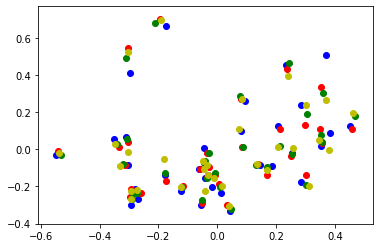

layer 15 : 192


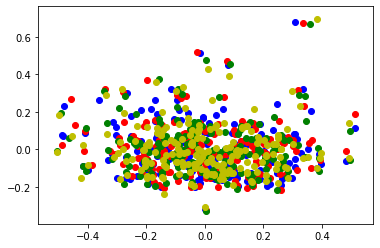

layer 16 : 192


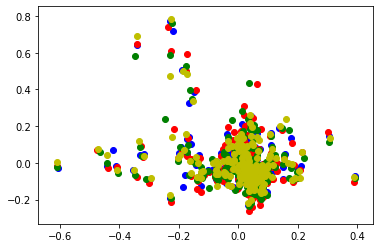

layer 17 : 32


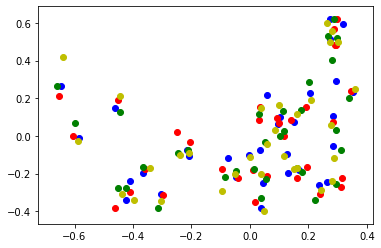

layer 18 : 192


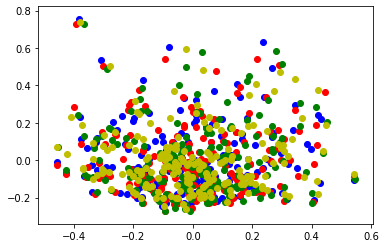

layer 19 : 192


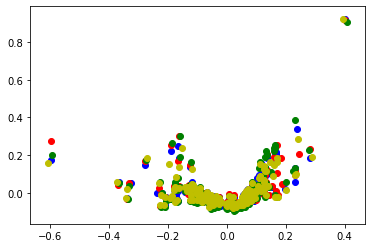

layer 20 : 64


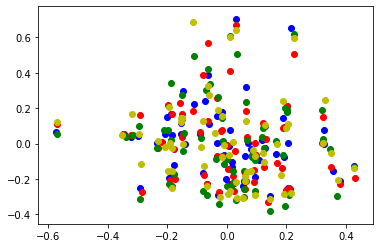

layer 21 : 384


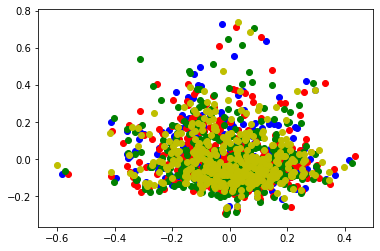

layer 22 : 384


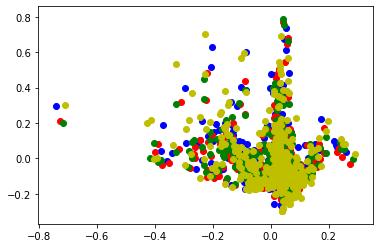

layer 23 : 64


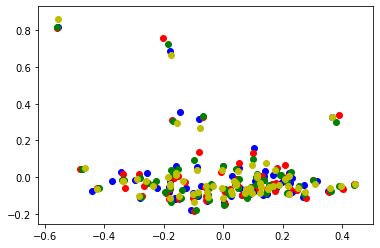

layer 24 : 384


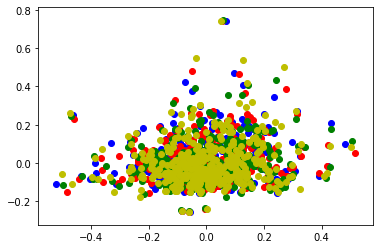

layer 25 : 384


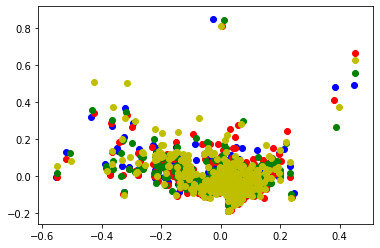

layer 26 : 64


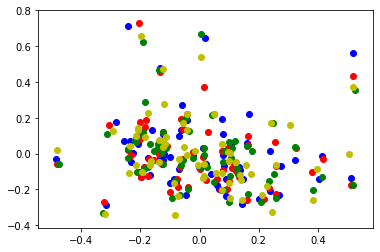

layer 27 : 384


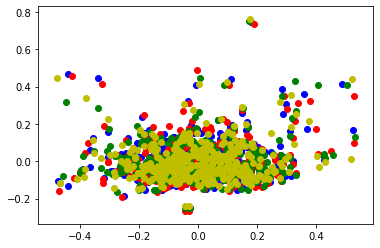

layer 28 : 384


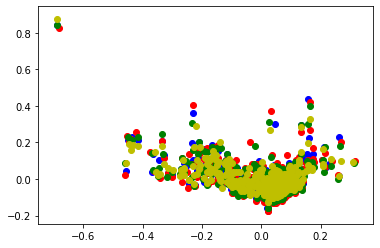

layer 29 : 64


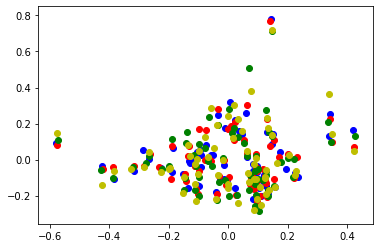

layer 30 : 384


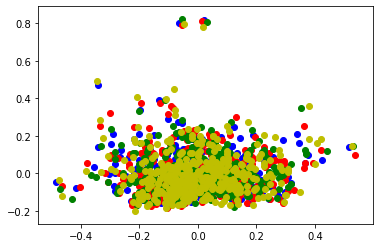

layer 31 : 384


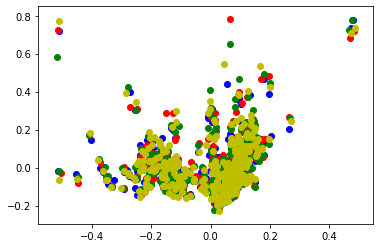

layer 32 : 96


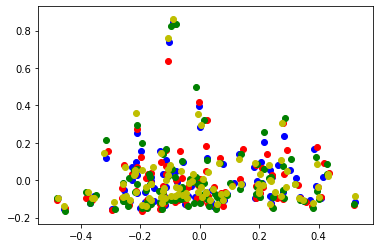

layer 33 : 576


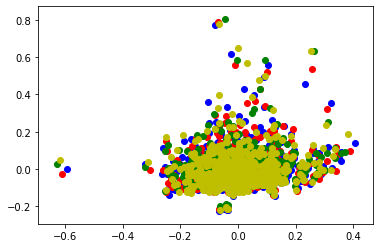

layer 34 : 576


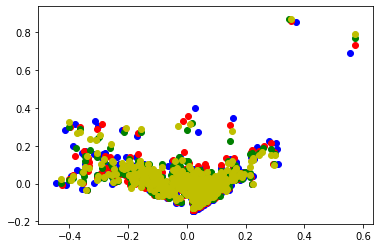

layer 35 : 96


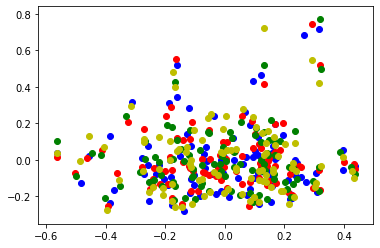

layer 36 : 576


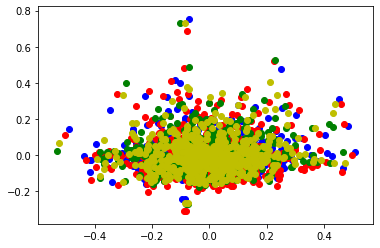

layer 37 : 576


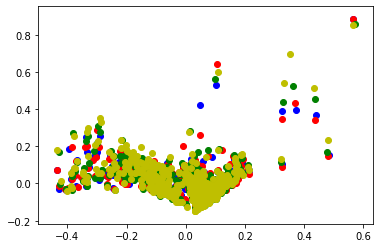

layer 38 : 96


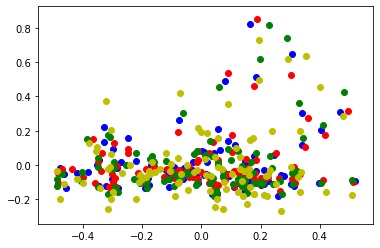

layer 39 : 576


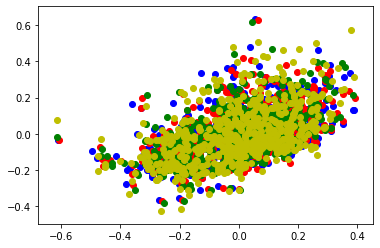

layer 40 : 576


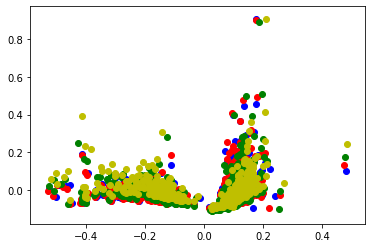

layer 41 : 160


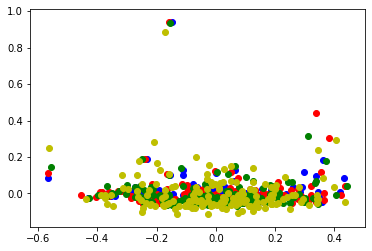

layer 42 : 960


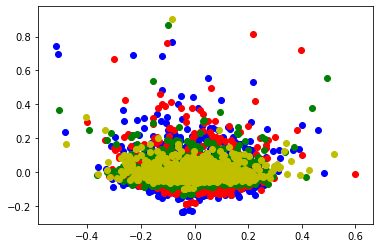

layer 43 : 960


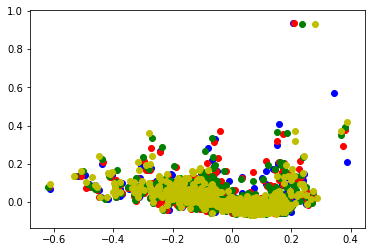

layer 44 : 160


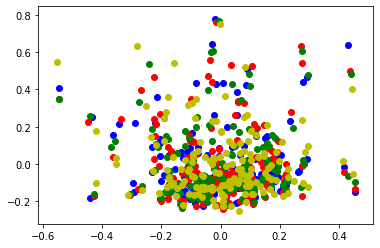

layer 45 : 960


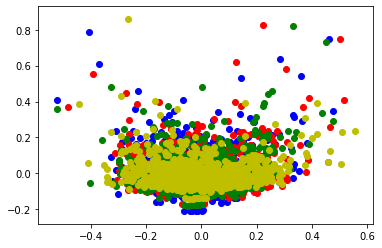

layer 46 : 960


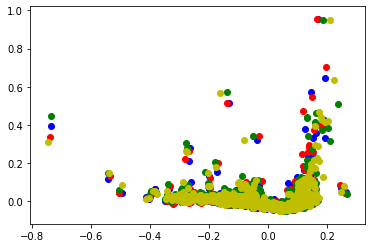

layer 47 : 160


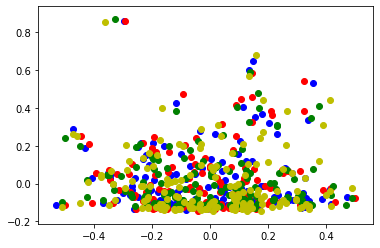

layer 48 : 960


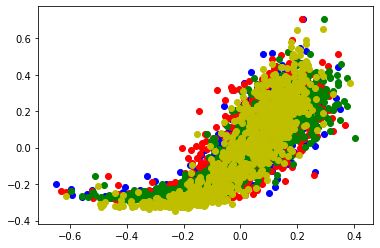

layer 49 : 960


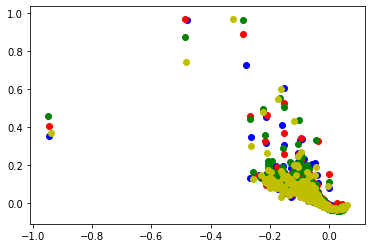

layer 50 : 320


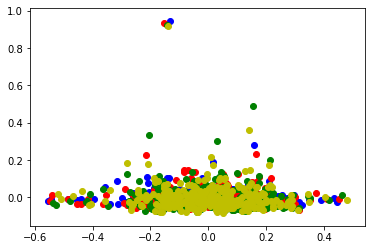

layer 51 : 256


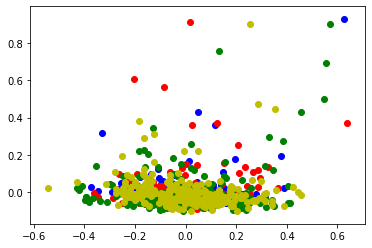

layer 52 : 256


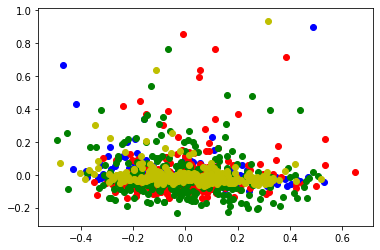

layer 53 : 256


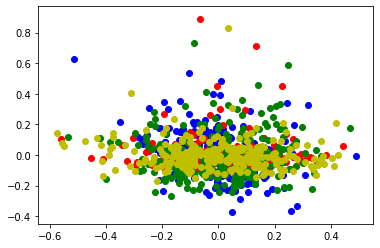

layer 54 : 256


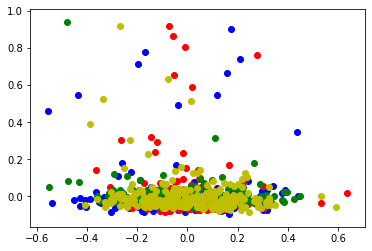

layer 55 : 256


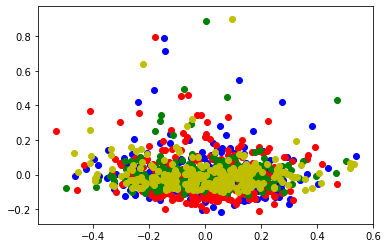

layer 56 : 256


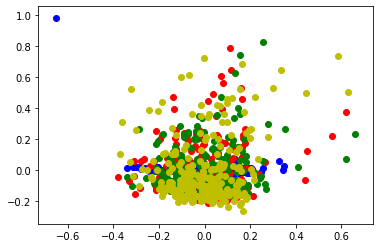

layer 57 : 48


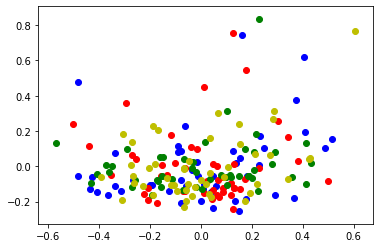

layer 58 : 256


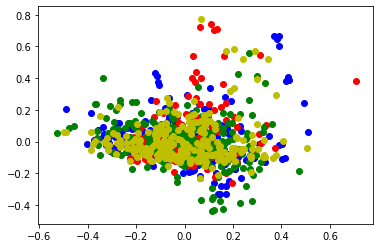

layer 59 : 256


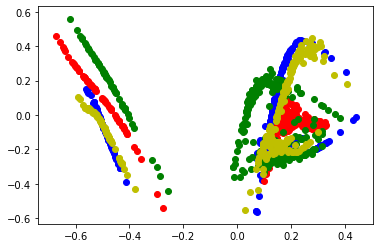

In [33]:
for i in range(len(mean_s)):
    print('layer', i, ':', len(mean_s[i]))
    plt.scatter((mean_s[i] - torch.mean(mean_s[i])) /(torch.max(mean_s[i])-torch.min(mean_s[i])), (var_s[i] - torch.mean(var_s[i]))/(torch.max(var_s[i])-torch.min(var_s[i])), c='b')
    plt.scatter((mean_v[i] - torch.mean(mean_v[i])) /(torch.max(mean_v[i])-torch.min(mean_v[i])), (var_v[i] - torch.mean(var_v[i]))/(torch.max(var_v[i])-torch.min(var_v[i])), c='r')
    plt.scatter((mean_p[i] - torch.mean(mean_p[i])) /(torch.max(mean_p[i])-torch.min(mean_p[i])), (var_p[i] - torch.mean(var_p[i]))/(torch.max(var_p[i])-torch.min(var_p[i])), c='g')
    plt.scatter((mean_k[i] - torch.mean(mean_k[i])) /(torch.max(mean_k[i])-torch.min(mean_k[i])), (var_k[i] - torch.mean(var_k[i]))/(torch.max(var_k[i])-torch.min(var_k[i])), c='y')
    plt.show()
    
#     plt.scatter(mean_s[i]-torch.mean(mean_s[i])/torch.var(mean_s[i]), var_s[i]-torch.mean(var_s[i])/torch.var(var_s[i]), c='b')
#     plt.scatter(mean_v[i]-torch.mean(mean_v[i])/torch.var(mean_v[i]), var_v[i]-torch.mean(var_v[i])/torch.var(var_v[i]), c='r')
#     plt.scatter(mean_p[i]-torch.mean(mean_p[i])/torch.var(mean_p[i]), var_p[i]-torch.mean(var_p[i])/torch.var(var_p[i]), c='g')
#     plt.scatter(mean_k[i]-torch.mean(mean_k[i])/torch.var(mean_k[i]), var_k[i]-torch.mean(var_k[i])/torch.var(var_k[i]), c='y')